In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error


In [2]:
df = pd.read_csv("../data/dataproject2025_preprocessed.csv")
df.head()

,num__issue_d,num__loan duration,num__annual_inc,num__avg_cur_bal,num__bc_open_to_buy,num__bc_util,num__delinq_2yrs,num__dti,num__fico_range_high,num__funded_amnt,...,cat__sub_grade_F2,cat__sub_grade_F3,cat__sub_grade_F4,cat__sub_grade_F5,cat__sub_grade_G1,cat__sub_grade_G2,cat__sub_grade_G3,cat__sub_grade_G4,cat__sub_grade_G5,Predicted probabilities
0,-1.687635,-0.637761,-0.740512,-0.745082,0.749479,-1.586997,-0.370384,-1.880644,2.106130,-1.180039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053051
1,-1.687635,-0.637761,-0.470965,-0.250508,0.416937,-0.242629,-0.370384,0.530276,1.258044,1.180387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084507
2,-1.687635,-0.637761,4.254853,2.390279,0.248935,0.226833,-0.370384,0.019227,1.766896,1.281169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037206
3,-1.687635,-0.637761,0.841762,1.367198,-0.426078,1.147974,-0.370384,-0.633779,0.749193,-0.416216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061371
4,-1.687635,1.567986,-0.155910,0.630499,-0.342077,0.497129,0.729341,0.561034,-0.946979,1.238734,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.345896


In [5]:
X = df.drop(columns = ["Predicted probabilities"])
y = df["Predicted probabilities"]

In [6]:

# Linear regression surrogate
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Decision tree surrogate
tree_reg = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_reg.fit(X, y)


DecisionTreeRegressor(max_depth=4, random_state=42)

In [7]:


y_pred_lin = lin_reg.predict(X)
y_pred_tree = tree_reg.predict(X)

print("Linear Regression - R²:", r2_score(y, y_pred_lin))
print("Linear Regression - MSE:", mean_squared_error(y, y_pred_lin))

print("Decision Tree - R²:", r2_score(y, y_pred_tree))
print("Decision Tree - MSE:", mean_squared_error(y, y_pred_tree))


Linear Regression - R²: 0.9644002890846071
Linear Regression - MSE: 0.0005022593257592302
Decision Tree - R²: 0.7872821420541873
Decision Tree - MSE: 0.003001134704793777


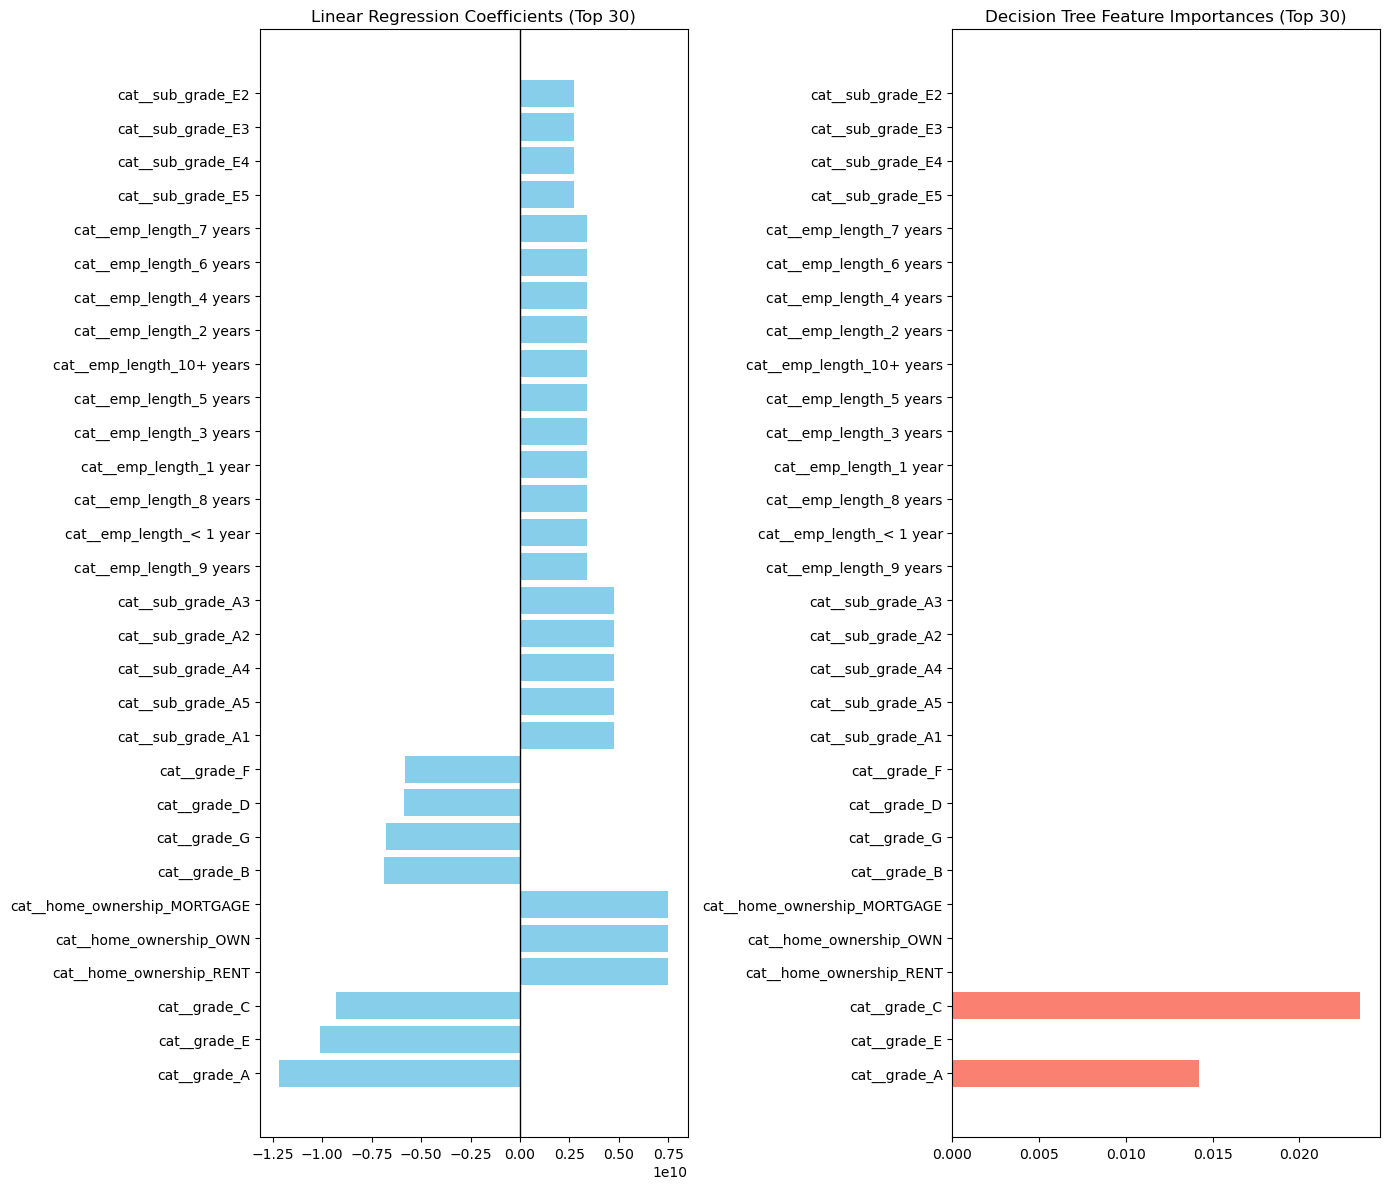

In [8]:


# Collect coefficients from Linear Regression
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Linear_Coefficient": lin_reg.coef_
})

# Collect importances from Decision Tree
importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Tree_Importance": tree_reg.feature_importances_
})

# Merge both
comparison_df = coef_df.merge(importances_df, on="Feature")

# Rank by absolute values from either model
comparison_df["Rank"] = (
    comparison_df["Linear_Coefficient"].abs() + comparison_df["Tree_Importance"]
)

# Keep top 30
top30 = comparison_df.sort_values(by="Rank", ascending=False).head(30)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 12))

# Linear Regression Coefficients
axes[0].barh(top30["Feature"], top30["Linear_Coefficient"], color="skyblue")
axes[0].set_title("Linear Regression Coefficients (Top 30)")
axes[0].axvline(0, color="black", linewidth=1)

# Decision Tree Importances
axes[1].barh(top30["Feature"], top30["Tree_Importance"], color="salmon")
axes[1].set_title("Decision Tree Feature Importances (Top 30)")

plt.tight_layout()
plt.show()


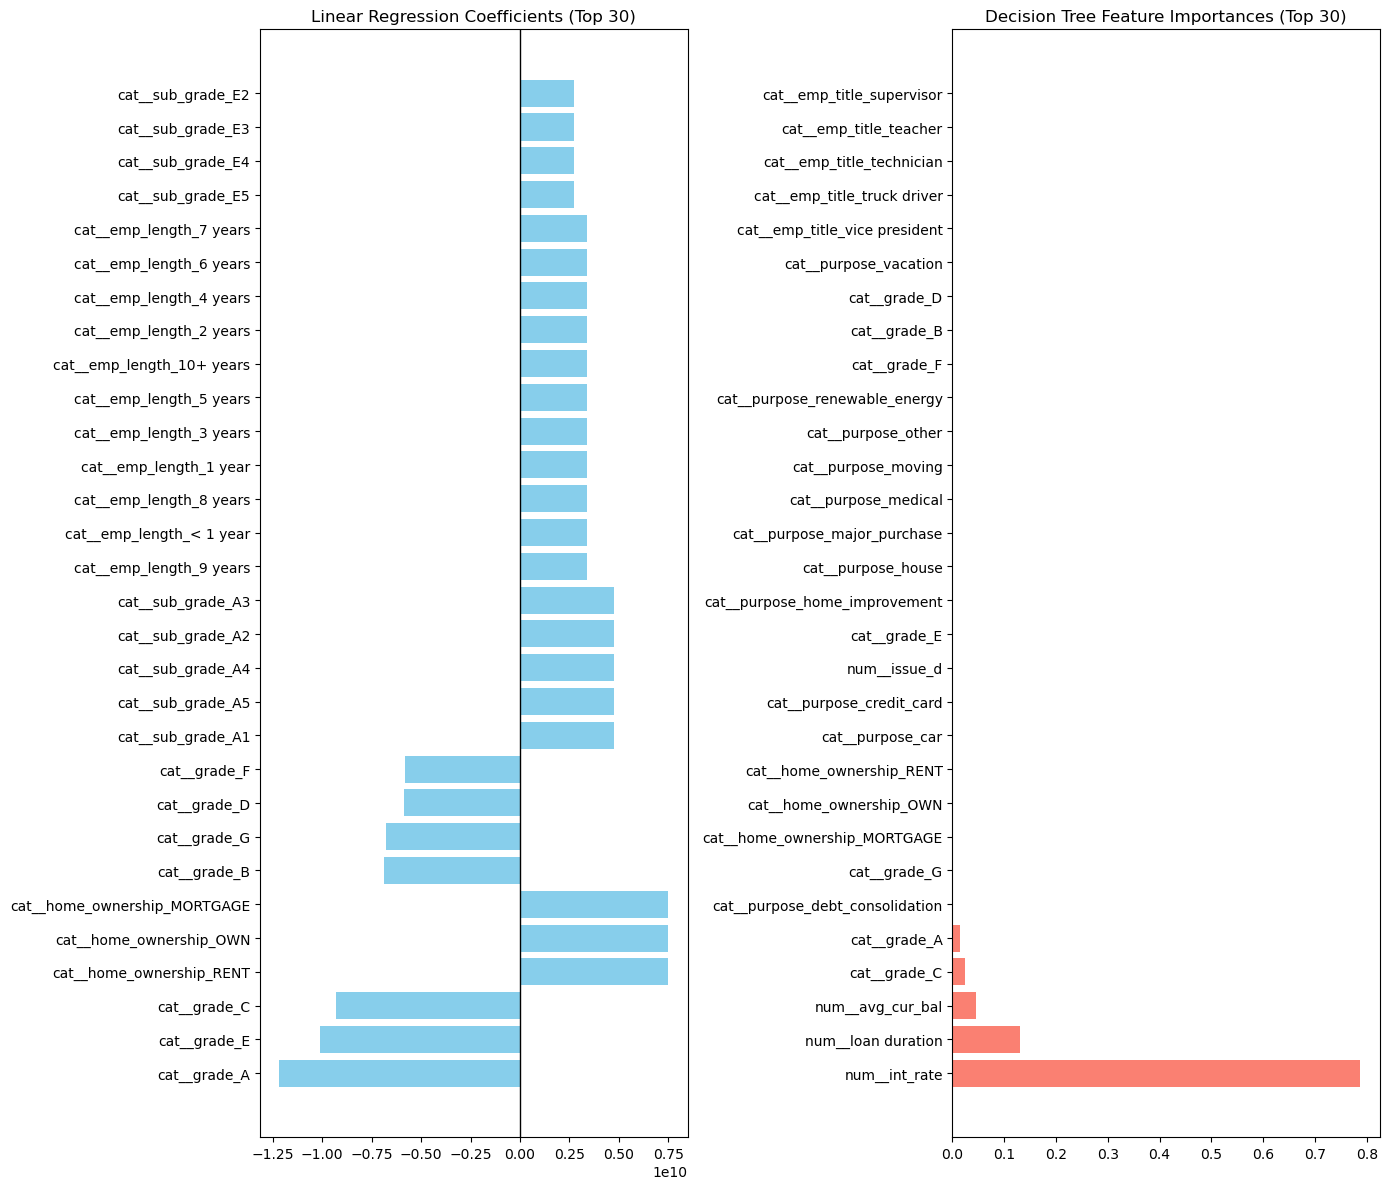

In [9]:
# Top 30 for Linear Regression
top30_lin = coef_df.reindex(coef_df["Linear_Coefficient"].abs().sort_values(ascending=False).index).head(30)

# Top 30 for Decision Tree
top30_tree = importances_df.sort_values(by="Tree_Importance", ascending=False).head(30)

# Plot separately
fig, axes = plt.subplots(1, 2, figsize=(14, 12))

# Linear Regression Coefficients
axes[0].barh(top30_lin["Feature"], top30_lin["Linear_Coefficient"], color="skyblue")
axes[0].set_title("Linear Regression Coefficients (Top 30)")
axes[0].axvline(0, color="black", linewidth=1)

# Decision Tree Importances
axes[1].barh(top30_tree["Feature"], top30_tree["Tree_Importance"], color="salmon")
axes[1].set_title("Decision Tree Feature Importances (Top 30)")

plt.tight_layout()
plt.show()
